__Arturo Rodriguez__
# Development and Evaluation of a Supervised Model
### Instructions
1. Filter the “loan_status” variable to only contain “Charged Off” and “Fully Paid”.
2. Using the “loan_status” variable as the outcome and spliting the data into train and test sets, use the other variables below to develop the most appropriate type of classification model with the train dataset that predicts whether the loan_status should be “Charged Off” or “Fully Paid” on the test dataset.
3. Exploratory analysis, model development, and model performance metric(s) are left to the discretion of the applicant.

### Assessment
The script developed by the applicant will be assessesd for:
-  __Data pre-processing__
-  __Model selection and development__
-  __Interpretation of model performance__

In [1]:
import numpy as np
import pandas as pd # using version 0.24.1
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time

In [2]:
# Import data
df = pd.read_csv('loan.csv')

/Users/arodriguez/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Initial dataframe exploration

In [3]:
# Check the size
df.shape

(887379, 74)

In [4]:
# Quick first view of the original dataframe
df.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data pre-processing

-  First, we are told to use only a list of features.
-  Second, we'll only keep those rows where 'loan_status' is 'Charged Off' or 'Fully Paid'
-  Third, we'll do a deeper exploration of every feature

In [5]:
# Let's put 'loan_status' at the beginning since this variable is used as the outcome one.

features = ["loan_status", "dti", "annual_inc", "delinq_2yrs", "inq_last_6mths", "open_acc", "pub_rec",
"revol_bal", "revol_util", "total_acc", "out_prncp", "out_prncp_inv", "total_pymnt", "total_pymnt_inv",
"total_rec_prncp", "total_rec_int", "total_rec_late_fee", "recoveries", "collection_recovery_fee",
"last_pymnt_amnt", "collections_12_mths_ex_med", "purpose", "home_ownership",
"grade", "emp_length", "term", "addr_state", "verification_status", "application_type"]

# Dropping every other column
df = df[features]

df.shape

(887379, 29)

In [6]:
# As expected we've reduce the dataframe from 74 to 29 features, including the outcome variable 'loan_status'

# Before filtering the 'loan_status' variable, let's see it's distribution:
df['loan_status'].value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

It's important to note that we have 207k 'Fully Paid' loans and 45k 'Charged Off'.
Now let's drop the rest of the rows

In [7]:
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]

df.shape

(252971, 29)

In [8]:
# As expected, we've dropped over 600k rows, over the 68% of the total of the initial dataframe

df.head()

,loan_status,dti,annual_inc,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,...,last_pymnt_amnt,collections_12_mths_ex_med,purpose,home_ownership,grade,emp_length,term,addr_state,verification_status,application_type
0,Fully Paid,27.65,24000.0,0.0,1.0,3.0,0.0,13648.0,83.7,9.0,...,171.62,0.0,credit_card,RENT,B,10+ years,36 months,AZ,Verified,INDIVIDUAL
1,Charged Off,1.00,30000.0,0.0,5.0,3.0,0.0,1687.0,9.4,4.0,...,119.66,0.0,car,RENT,C,< 1 year,60 months,GA,Source Verified,INDIVIDUAL
2,Fully Paid,8.72,12252.0,0.0,2.0,2.0,0.0,2956.0,98.5,10.0,...,649.91,0.0,small_business,RENT,C,10+ years,36 months,IL,Not Verified,INDIVIDUAL
3,Fully Paid,20.00,49200.0,0.0,1.0,10.0,0.0,5598.0,21.0,37.0,...,357.48,0.0,other,RENT,C,10+ years,36 months,CA,Source Verified,INDIVIDUAL
5,Fully Paid,11.20,36000.0,0.0,3.0,9.0,0.0,7963.0,28.3,12.0,...,161.03,0.0,wedding,RENT,A,3 years,36 months,AZ,Source Verified,INDIVIDUAL


In [9]:
# Let's see if any column has only one unique value, and drop those afterwards
df_unique = df.nunique()
df_unique

loan_status                        2
dti                             3978
annual_inc                     19483
delinq_2yrs                       22
inq_last_6mths                     9
open_acc                          59
pub_rec                           14
revol_bal                      47316
revol_util                      1199
total_acc                        105
out_prncp                          1
out_prncp_inv                      1
total_pymnt                   242391
total_pymnt_inv               235567
total_rec_prncp                44945
total_rec_int                 182889
total_rec_late_fee              4448
recoveries                     22627
collection_recovery_fee        20529
last_pymnt_amnt               199266
collections_12_mths_ex_med         7
purpose                           14
home_ownership                     6
grade                              7
emp_length                        11
term                               2
addr_state                        51
v

In [10]:
# It seems the features 'out_prncp' and 'out_prncp_inv' are linearly independent. Let's drop them
df = df[ [ df_unique.index[i] for i,f in enumerate(df_unique) if f > 1] ]

In [11]:
df.shape

(252971, 27)

In [12]:
# Everything seems alright now, let's look a bit more into it :D
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252971 entries, 0 to 887371
Data columns (total 27 columns):
loan_status                   252971 non-null object
dti                           252971 non-null float64
annual_inc                    252971 non-null float64
delinq_2yrs                   252971 non-null float64
inq_last_6mths                252971 non-null float64
open_acc                      252971 non-null float64
pub_rec                       252971 non-null float64
revol_bal                     252971 non-null float64
revol_util                    252772 non-null float64
total_acc                     252971 non-null float64
total_pymnt                   252971 non-null float64
total_pymnt_inv               252971 non-null float64
total_rec_prncp               252971 non-null float64
total_rec_int                 252971 non-null float64
total_rec_late_fee            252971 non-null float64
recoveries                    252971 non-null float64
collection_recovery_fee   

#### Since this is a fast exploratory analysis and the dataset is not huge, we won't spend much time in changing the type of the columns, but it's usually worth it to use int instead of float, specially when we're working with massive datasets
#### At first, most values are non-null for every feature, which is a good signal.
#### It's important to tell that we have several numerical features, and some other categorical features.
#### Let's start with the numerical ones after splitting the data

In [13]:
# Mapping the outcome variable 'loan_status' as:
# 'Fully Paid' = 0
# 'Charged Off' = 1
df['loan_status'] = df['loan_status'].map( {'Fully Paid': 0, 'Charged Off': 1} ).astype(bool)

## Split
Since we are going to start getting our hands dirty now, it's the moment to split our dataframe. We'll do:
-  70% training set
-  30% test set

In [14]:
np.random.seed(seed=1)
msk = np.random.rand(len(df)) < 0.7

train = df[msk]
test = df[~msk]
del df # we won't need it anymore, and deleting it will save us some future warnings 

In [15]:
train.describe()

,dti,annual_inc,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med
count,176988.000000,1.769880e+05,176988.000000,176988.000000,176988.000000,176988.000000,1.769880e+05,176857.000000,176988.000000,176988.000000,176988.000000,176988.000000,176988.000000,176988.000000,176988.000000,176988.000000,176988.000000,176946.000000
mean,16.538735,7.255320e+04,0.250090,0.853013,10.935770,0.143784,1.516392e+04,54.296753,25.034827,13599.013688,13500.674122,11492.505949,1945.954525,0.730582,159.822636,16.784877,6460.285564,0.006742
std,7.783796,5.848663e+04,0.744488,1.067798,4.895757,0.437090,1.909582e+04,24.809142,11.732661,9488.882695,9490.520517,8343.447206,2065.281802,5.528247,751.365162,116.084242,7360.970276,0.087313
min,0.000000,3.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.750000,4.500000e+04,0.000000,0.000000,7.000000,0.000000,5.855000e+03,36.200000,16.000000,6388.776858,6289.795000,5000.000000,627.627500,0.000000,0.000000,0.000000,488.920000,0.000000
50%,16.200000,6.200000e+04,0.000000,1.000000,10.000000,0.000000,1.092800e+04,55.800000,23.000000,11434.950865,11345.535000,10000.000000,1308.090000,0.000000,0.000000,0.000000,3955.830000,0.000000
75%,21.990000,8.700000e+04,0.000000,1.000000,13.000000,0.000000,1.902000e+04,73.800000,32.000000,18615.632500,18494.460000,16000.000000,2486.760000,0.000000,0.000000,0.000000,10025.532500,0.000000
max,57.140000,8.706582e+06,29.000000,8.000000,76.000000,11.000000,1.746716e+06,892.300000,150.000000,57060.139914,57019.380000,35000.020000,22060.140000,358.680000,31900.520000,7002.190000,36475.590000,3.000000


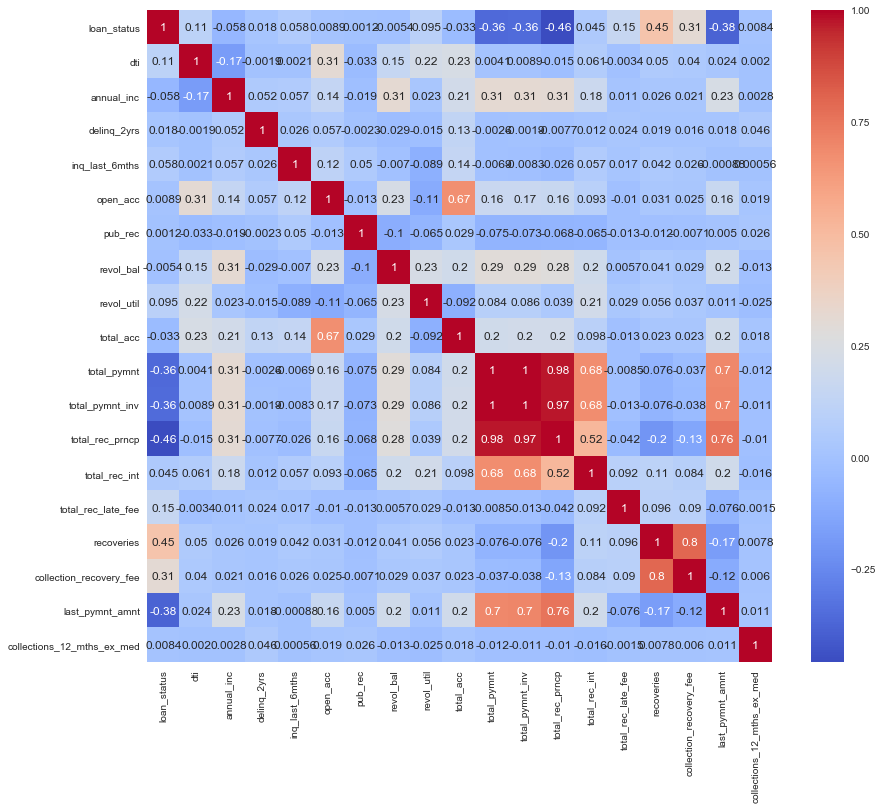

In [16]:
# It's always a great idea to do a quick heatmap of the correlations.
sns.set(font_scale=1)
plt.figure(figsize=(14,12))
sns.heatmap(train.corr(),cmap='coolwarm',annot=True)

#### Most of the features are not very correlated with 'loan_status'. We'll do quick boxplots and/or histogramas for each of them. Hopefully, we'll be able to rise those correlations a little bit
#### We can also see that some other features are highly correlated among them. We'll take care of it later.

###  Feature: dti
A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.

In [17]:
def boxplot(feature, fliers = True):
    sns.boxplot(x='loan_status', y=feature, data=train,showfliers= fliers)

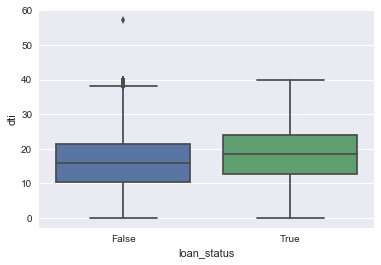

In [18]:
boxplot('dti')

### Feature: annual_inc
The self-reported annual income provided by the borrower during registration.

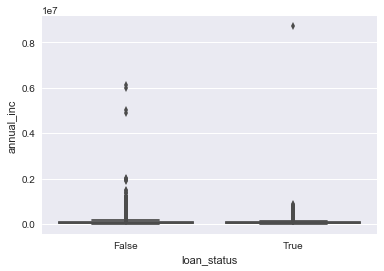

In [19]:
boxplot('annual_inc')

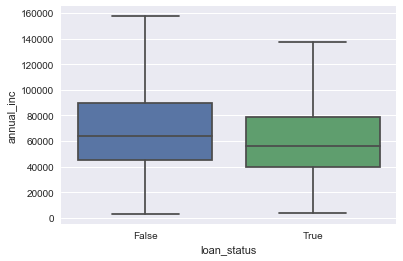

In [20]:
boxplot('annual_inc', fliers = False)

###  Feature: delinq_2yrs
The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years

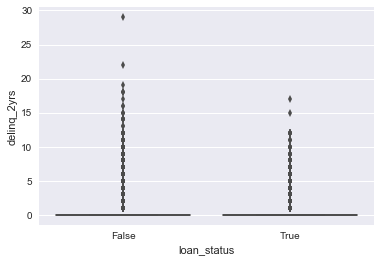

In [21]:
boxplot('delinq_2yrs')

In [22]:
train['loan_status'].corr(train['delinq_2yrs'])

0.017867660195192633

Most of the values are 0 for both 'Fully Paid' and 'Charged Off' loans.
<br>
Even outliers seem to occur in both types, it's not possible to transform this variable anyhow.
<br>
As expected, correlation is only 1.8%. If we were trying to do some kind of feature reduction, 'delinq_2yrs' would be a big candidate to drop. Though, since we don't have any kind of processing power problem and the dataset is not huge, we'll leave it by now.

###  Feature: inq_last_6mths
The number of inquiries in past 6 months (excluding auto and mortgage inquiries)

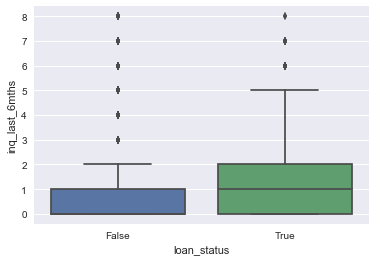

In [23]:
boxplot('inq_last_6mths')

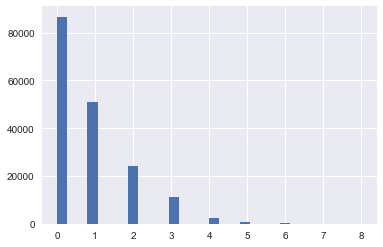

In [24]:
train['inq_last_6mths'].hist(bins = 30)

In [25]:
# For efficiency purposes, it seems safe to transform 'inq_last_6mths' from float64 to int8 (max value is 8)
train['inq_last_6mths'] = train['inq_last_6mths'].astype('int8')
test['inq_last_6mths'] = test['inq_last_6mths'].astype('int8')

###  Feature: open_acc
The number of open credit lines in the borrower's credit file.

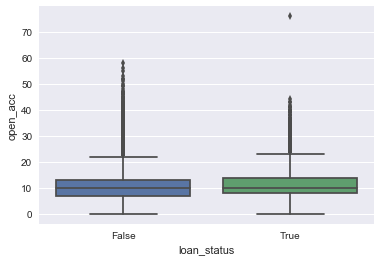

In [26]:
boxplot('open_acc')

###  Feature: pub_rec
Number of derogatory public records

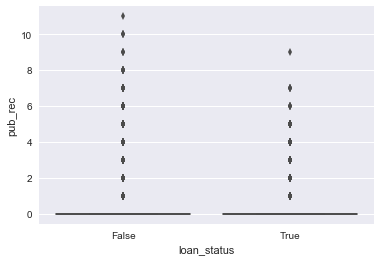

In [27]:
boxplot('pub_rec')

In [28]:
# For efficiency purposes, it seems safe to transform 'pub_rec' from float64 to int8 (max value is 15)
train['pub_rec'] = train['pub_rec'].astype('int8')
test['pub_rec'] = test['pub_rec'].astype('int8')

In [29]:
# Let's find out the distribution by 'loan_status', maybe we see something interesting
train[['loan_status','pub_rec', 'annual_inc']].pivot_table(index = 'pub_rec', columns = 'loan_status',  aggfunc = 'count')


annual_inc         
loan_status      False    True 
pub_rec                        
0             127401.0  27928.0
1              15737.0   3384.0
2               1451.0    348.0
3                387.0     78.0
4                117.0     36.0
5                 44.0     18.0
6                 25.0      4.0
7                 11.0      4.0
8                  7.0      NaN
9                  3.0      1.0
10                 3.0      NaN
11                 1.0      NaN

In [30]:
# Percentage of the total, by column
train[['loan_status','pub_rec', 'annual_inc']].pivot_table(index = 'pub_rec', columns = 'loan_status',  aggfunc = 'count').transform(lambda x: round(x/x.sum()*100,2).astype(str)+'%' )
                                                                                    

annual_inc        
loan_status      False   True 
pub_rec                       
0               87.75%  87.82%
1               10.84%  10.64%
2                 1.0%   1.09%
3                0.27%   0.25%
4                0.08%   0.11%
5                0.03%   0.06%
6                0.02%   0.01%
7                0.01%   0.01%
8                 0.0%    nan%
9                 0.0%    0.0%
10                0.0%    nan%
11                0.0%    nan%

Not a very useful variable. It will have a very low correlation as well, and it seems we cannot transform it into something more useful.

###  Feature: revol_bal
Total credit revolving balance

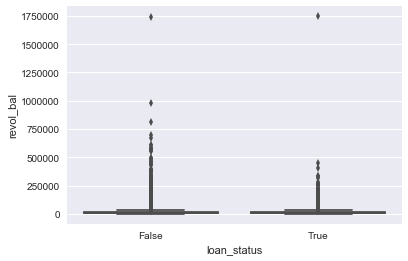

In [31]:
boxplot('revol_bal')

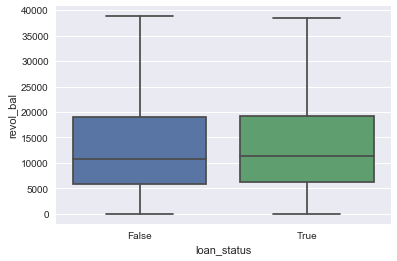

In [32]:
# Mmmm, let's do some zoom
boxplot('revol_bal', fliers = False)

False alarm, we can't do much here either :(

###  Feature: revol_util
Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.

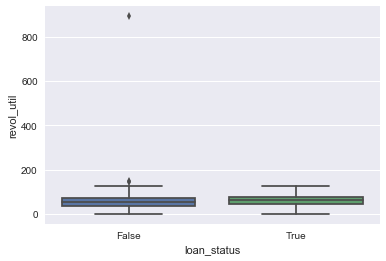

In [33]:
boxplot('revol_util')

In [34]:
# 'revol_util' was one of the few features that had missing values we have to take care of.
# The easiest thing will be to fill them with the median value (per each 'loan_status' value)

medians = {0: train[train['loan_status'] == False]['revol_util'].median(),
           1: train[train['loan_status'] == True]['revol_util'].median(),
          'train': train['revol_util'].median() # We'll fill new, null test data with the train dataset median
          }
medians

{0: 54.4, 1: 61.5, 'train': 55.8}

In [35]:
train.loc[(train['loan_status']==0) & train['revol_util'].isnull(), 'revol_util'] = medians[0]
train.loc[(train['loan_status']==1) & train['revol_util'].isnull(), 'revol_util'] = medians[1]
test['revol_util'] = test['revol_util'].fillna( medians['train'] )

###  Feature: total_acc
The total number of credit lines currently in the borrower's credit file

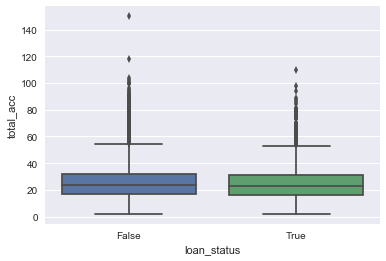

In [36]:
boxplot('total_acc')

In [37]:
# For efficiency purposes, it seems safe to transform 'total_acc' from float64 to int16 (max value is about 150)
train['total_acc'] = train['total_acc'].astype('int16')
test['total_acc'] = test['total_acc'].astype('int16')

###  Feature: total_pymnt
Payments received to date for total amount funded

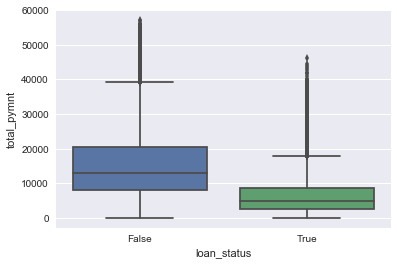

In [38]:
boxplot('total_pymnt')

###  Feature: total_pymnt_inv
Payments received to date for portion of total amount funded by investors

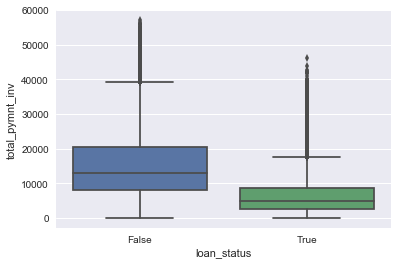

In [39]:
boxplot('total_pymnt_inv')

As we could see in the heatmap, 'total_pymnt_inv' is highly correlated to 'total_pymnt'.

###  Feature: total_rec_prncp
Principal received to date

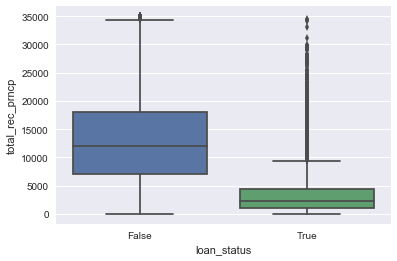

In [40]:
boxplot('total_rec_prncp')

###  Feature: total_rec_int
Interest received to date

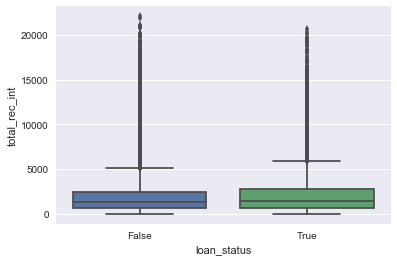

In [41]:
boxplot('total_rec_int')

###  Feature: total_rec_late_fee
Late fees received to date

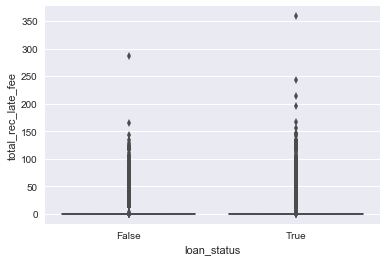

In [42]:
boxplot('total_rec_late_fee')

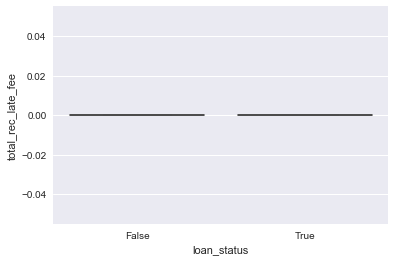

In [43]:
# Let's do some zoom, just in case
boxplot('total_rec_late_fee', fliers = False)

:-(

###  Feature: recoveries
post charge off gross recovery

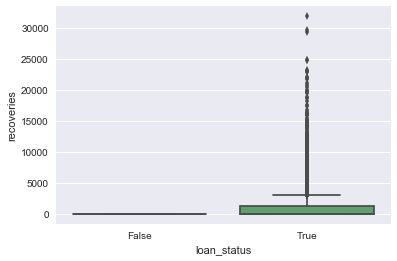

In [44]:
boxplot('recoveries')

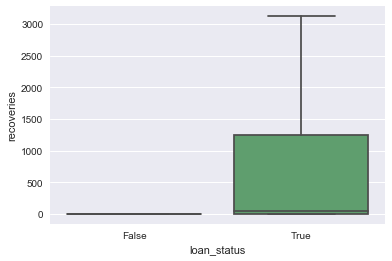

In [45]:
boxplot('recoveries', fliers=False)

In [46]:
# Logically, it seems that, whenever 'loan_status' is Fully Paid (0),
# 'recoveries' is 0, let's confirm this numerically
train.loc[train['loan_status'] == 0]['recoveries'].value_counts()

0.0    145187
Name: recoveries, dtype: int64

In [47]:
# But, let's also confirm that, when 'recoveries' = 0, it doesn't always mean that 'loan_status' is 0 or 1
train.loc[train['loan_status'] == 1]['recoveries'].value_counts().head(3)

0.0      14783
200.0        8
10.2         7
Name: recoveries, dtype: int64

It's good to know that almost half of 'Charged Off' loans' recoveries are also equal to 0.
<br>
Actually, knowing this, it makes sense to transform 'recoveries' to a new bynary feature where:
-  'recoveries' = 0, if the original 'recoveries' is 0 and
-  'recoveries' = 1, if the original 'recoveries' is greater than 0 

Right now, the correlation is 45% (see previous heatmap). __SPOILER ALERT!!__ By doing this, the correlation will go up to 70% :D

In [48]:
train['recoveries'] = train['recoveries'].apply(lambda x: 0 if x == 0 else 1).astype(bool)
# Being fair, we can apply the same rule to the test data,
# because we would be able to apply it as new data comes in
test['recoveries'] = test['recoveries'].apply(lambda x: 0 if x == 0 else 1).astype(bool)

###  Feature: collection_recovery_fee
post charge off collection fee

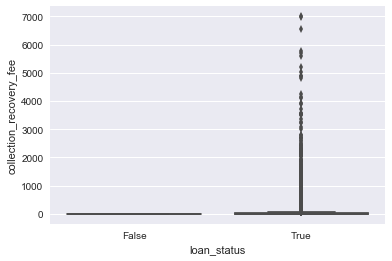

In [49]:
boxplot('collection_recovery_fee')

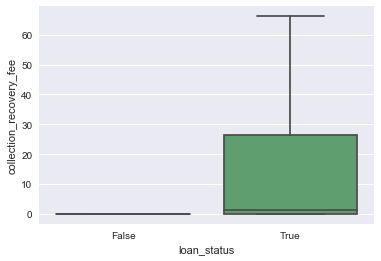

In [50]:
boxplot('collection_recovery_fee', fliers=False)

As we could expect, something similar to 'recoveries' occurs to 'collection_recovery_fee'. We'll have to check these two variables correlations later though, in the meantime, it makes sense to follow the same procedure as in 'recoveries' 

In [51]:
train['collection_recovery_fee'] = train['collection_recovery_fee'].apply(lambda x: 0 if x == 0 else 1).astype(bool)
test['collection_recovery_fee'] = test['collection_recovery_fee'].apply(lambda x: 0 if x == 0 else 1).astype(bool)
# It's valid to apply this to the test dataset


###  Feature: last_pymnt_amnt
Last total payment amount received

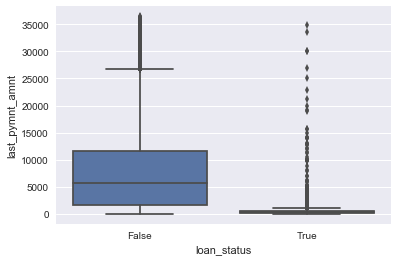

In [52]:
boxplot('last_pymnt_amnt')

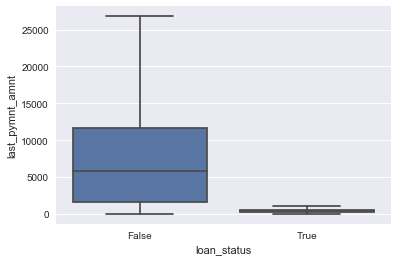

In [53]:
boxplot('last_pymnt_amnt', fliers=False)

It looks like most of the 'last_pymnt_amnt' for status_loan = 1 are below certain value. Let's find out that value :D

Text(0.5,0.98,'Histogram of the feature last_pymnt_amnt when loan_status = 1')

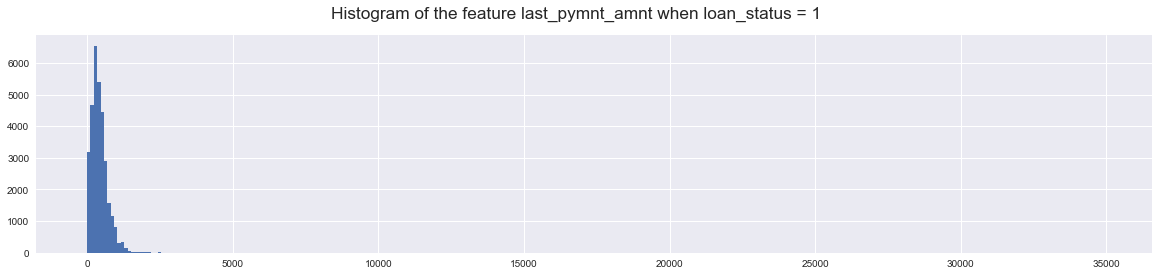

In [54]:
plt.figure(figsize=(20,4))
train.loc[train['loan_status'] == 1]['last_pymnt_amnt'].hist(bins = 300)
plt.suptitle('Histogram of the feature last_pymnt_amnt when loan_status = 1', fontsize = 'x-large')

In [55]:
train.loc[train['loan_status'] == 1]['last_pymnt_amnt'].describe()

count    31801.000000
mean       454.262073
std        669.082811
min          0.000000
25%        235.280000
50%        374.870000
75%        568.700000
max      34833.350000
Name: last_pymnt_amnt, dtype: float64

In [56]:
quantiles = [.85, .9, .95, .96, .965, .97, .98, .99, .995]
thresholds = train.loc[train['loan_status'] == 1]['last_pymnt_amnt'].quantile(quantiles).tolist()
print('quantile|thershold')
for quantile,threshold in zip(quantiles,thresholds):
    print(quantile,'|', round(threshold))

quantile|thershold
0.85 | 693
0.9 | 808
0.95 | 971
0.96 | 1014
0.965 | 1046
0.97 | 1101
0.98 | 1217
0.99 | 1378
0.995 | 2000


In [57]:
# Current correlation is -38% (see previous heatmap).
# Let's try to find the threshold value to obtain the maximum correlation when transforming 'last_pymnt_amnt' to a dummy variable.
print('Quantiles|Threshold|Correlation')
for quantile, threshold in zip(quantiles,thresholds):
    print(quantile,'|',round(threshold,2),'|',round(train['loan_status'].corr(train['last_pymnt_amnt'].apply(lambda x: 0 if x <= threshold else 1).astype(bool)),4))



Quantiles|Threshold|Correlation
0.85 | 693.06 | -0.5467
0.9 | 808.42 | -0.57
0.95 | 970.65 | -0.5922
0.96 | 1014.05 | -0.5958
0.965 | 1046.46 | -0.5973
0.97 | 1101.0 | -0.5975
0.98 | 1216.94 | -0.5968
0.99 | 1378.5 | -0.5948
0.995 | 2000.0 | -0.5637


Apparently, by choosing our thershold to be 1101, we'll obtain our most negative correlation.

Choosing the quantile 97, let's transform 'last_pymnt_amnt' to a binary feature where:
-  'last_pymnt_amnt' = 0, if the original 'last_pymnt_amnt' <= 1101
-  'last_pymnt_amnt' = 1, if the original 'last_pymnt_amnt' > 1101

__Note: It's valid to apply this rule to the test data, since we don't exactly know which is the maximum threshold there, we're assuming it will be similar__

In [58]:
train['last_pymnt_amnt'] = train['last_pymnt_amnt'].apply(lambda x: 0 if x <= 1101 else 1).astype(bool)
test['last_pymnt_amnt'] = test['last_pymnt_amnt'].apply(lambda x: 0 if x <= 1101 else 1).astype(bool)

We have transformed 'recoverires', 'collection_recovery_fee' and 'last_pymnt_amnt'. Fortunately, these three features didn't have any null value, otherwise, we could have filled those following the rules we just set.

###  Feature: collections_12_mths_ex_med
Number of collections in 12 months excluding medical collections

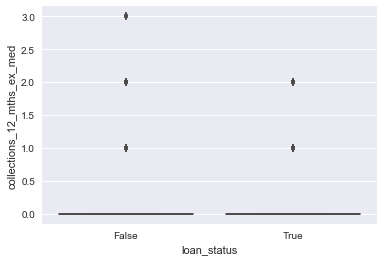

In [59]:
boxplot('collections_12_mths_ex_med')

In [60]:
# In this case, it just make sense to fill those few missing values with 0

train['collections_12_mths_ex_med'] = train['collections_12_mths_ex_med'].fillna(value=0)
# We just would do the same with new, missing, test data
test['collections_12_mths_ex_med'] = test['collections_12_mths_ex_med'].fillna(value=0)

Most of the values are 0, and we could drop the column here if we were looking to reduce the number of features.
<br>
Let's see our correlations heatmap again

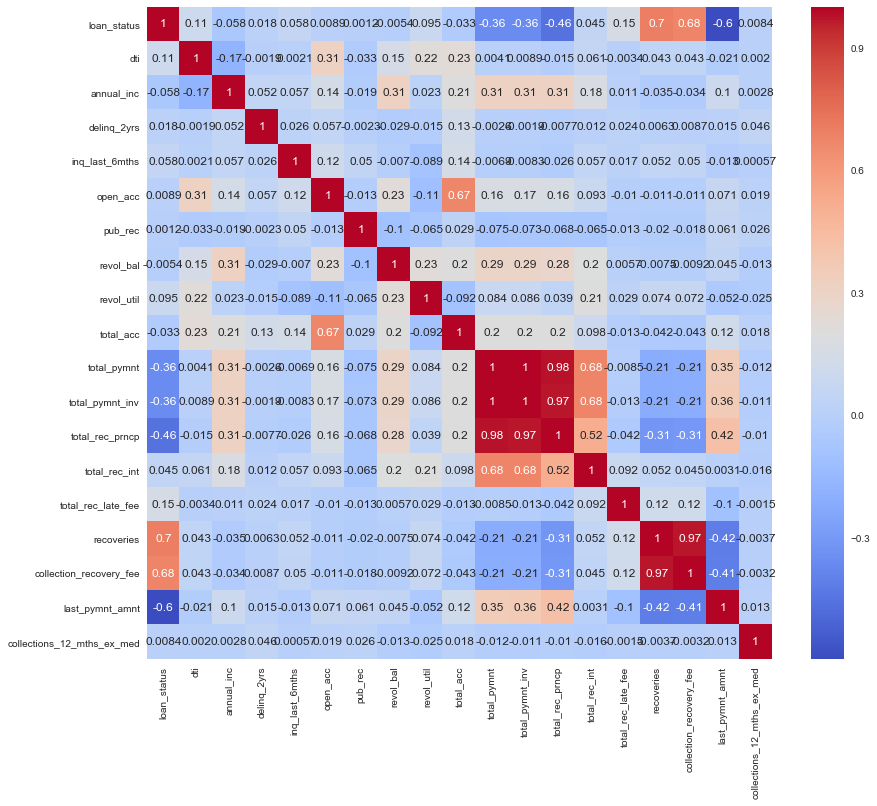

In [61]:
sns.set(font_scale=1)
plt.figure(figsize=(14,12))
sns.heatmap(train.corr(),cmap='coolwarm',annot=True)

I usually tend to drop those features that are highly correlated (> 0.95), though since we have enough resources and this is not a huge dataset, __we won't drop columns this time.__
<br><br>
But, if we did:
<br>
-  First, we see that 'total_pymnt', 'total_pymnt_inv' and 'total_rec_prncp' are highly correlated. Correlation of the last on is the most negative (-46%) so we would keep 'total_rec_prncp'.
Looking at 'total_pymnt' and 'total_rec_prncp', they have a 100% correlation among themselves, and -36% correlation with 'loan_status'.
-  Second, following a similar process, we could drop 'collection_recovery_fee'.

If necessary, we could also try to apply some kind of dimension reduction like PCA, if we don't lose too much variabilty, of course

## Categorical features
For each feature, we'll display __two charts: counts by category by loan_status, and 'Charged Off' rate by category__. Hopefully we'll be able to see interesting patterns and obtain high correlations

In [62]:
train[['loan_status','purpose','home_ownership', 'grade', 'emp_length', 'term', 'addr_state', 'verification_status', 'application_type']].head()

,loan_status,purpose,home_ownership,grade,emp_length,term,addr_state,verification_status,application_type
0,False,credit_card,RENT,B,10+ years,36 months,AZ,Verified,INDIVIDUAL
2,False,small_business,RENT,C,10+ years,36 months,IL,Not Verified,INDIVIDUAL
3,False,other,RENT,C,10+ years,36 months,CA,Source Verified,INDIVIDUAL
5,False,wedding,RENT,A,3 years,36 months,AZ,Source Verified,INDIVIDUAL
7,False,car,RENT,E,9 years,36 months,CA,Source Verified,INDIVIDUAL


#### We'll be transforming each categorical feature and mapping each cateogry to its 'Charged Off' rate. If worth it, we'll make different dummy variable groups.

In [63]:
# Setting palette:
# 0 = Fully Paid: Green
# 1 = Charged Off: Red
loan_palette = {0:'g', 1:'r'}

sns.set(font_scale=1.5)

def count(feature, label_rot = False):
    plt.figure(figsize=(20,5))
    ax = sns.countplot(x = feature,hue = 'loan_status',data = train, palette = loan_palette)
    if label_rot == True:
        ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

def rate(feature, label_rot = False):
    train_feature = train[['loan_status',feature]].groupby(feature).mean().reset_index().sort_values(by=['loan_status'])
    sns.set(font_scale=1.5)
    plt.figure(figsize=(20,5))
    ax = sns.barplot(x=feature, y = 'loan_status', data = train_feature, palette = 'YlOrRd')
    ax.set(ylabel='Charged Off rate')
    if label_rot == True:
        ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
    return train_feature
    
def map_to_rate(feature, train_feature):
    feature_dict = dict(zip(train_feature[feature], train_feature['loan_status']))
    train[feature] = train[feature].map(feature_dict)
    test[feature] = test[feature].map(feature_dict)
    # Notice we're mapping the test data with the results found out in the training data
    

### Feature: Purpose
A category provided by the borrower for the loan request. 

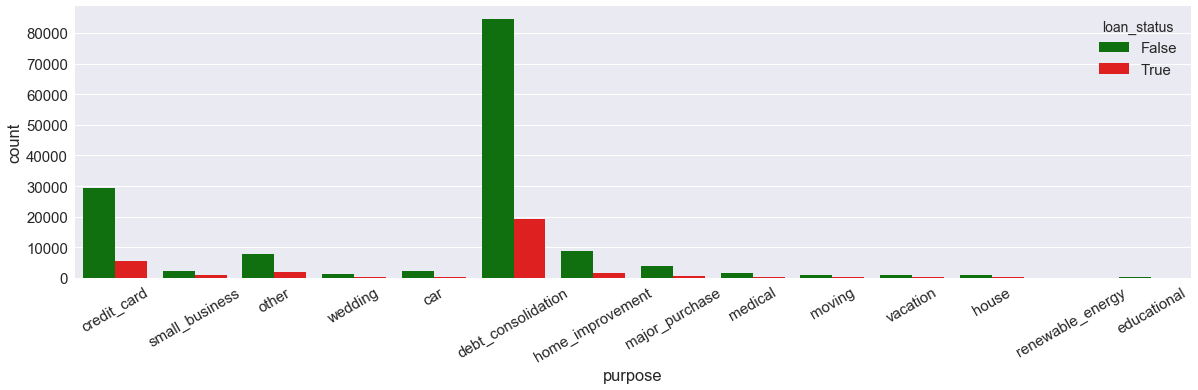

In [64]:
count('purpose', label_rot=True)

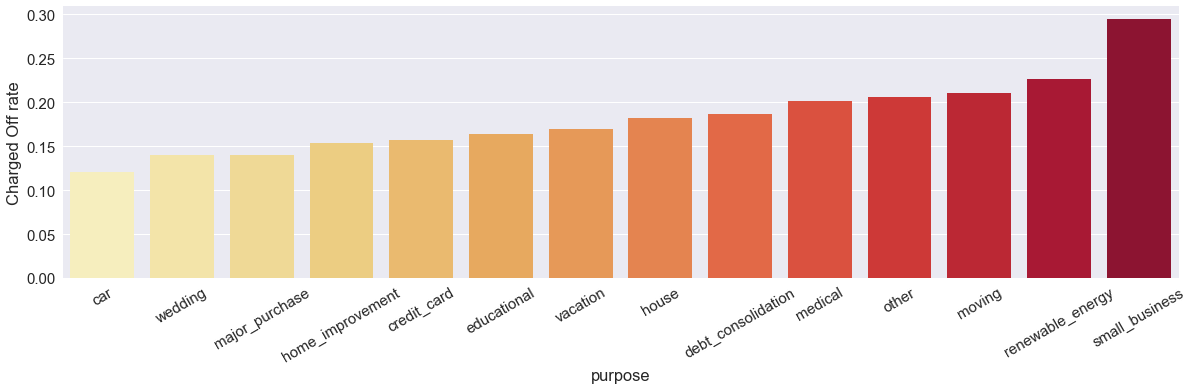

In [65]:
train_purpose = rate('purpose', label_rot = True)

In [66]:
# We could classify this in 3 to 6 groups, depending on how granular we want to get,
# and create a column with only 1 to 6 values.

# Though, as we said, let's map each category to its 'Charged Off' rate.
map_to_rate('purpose', train_purpose)

In [67]:
train['loan_status'].corr(train['purpose'])

0.06232240730929713

6% of correlation, better than nothing! :D :D

### Feature: Home_ownership
The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER.

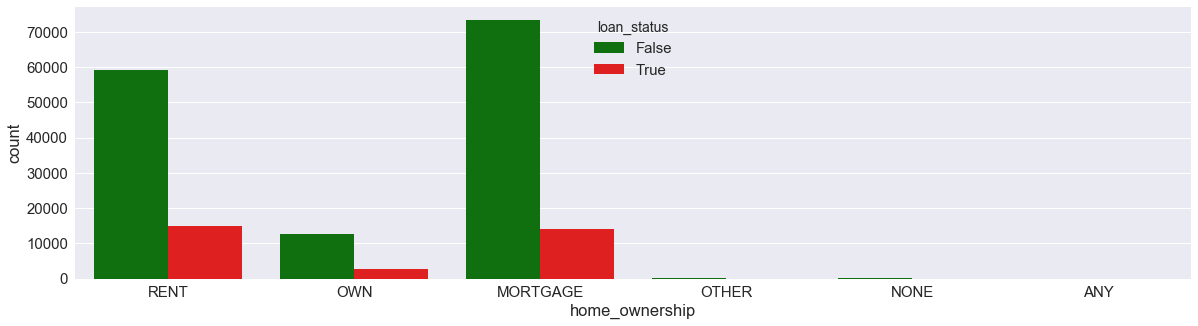

In [68]:
count('home_ownership')

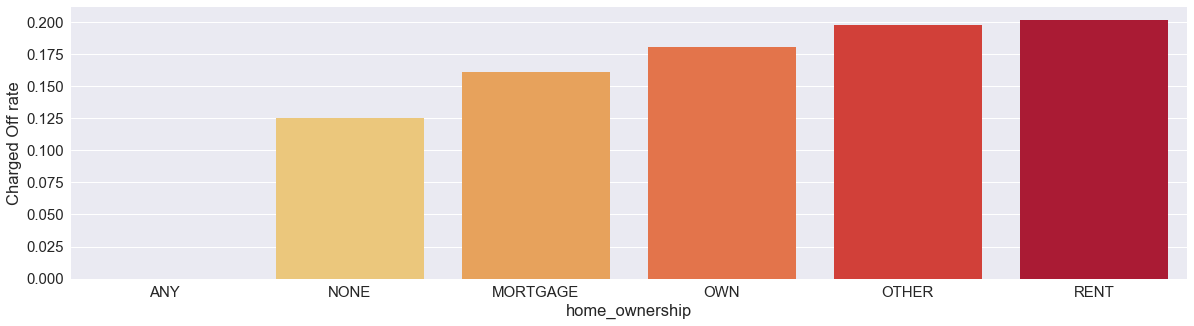

In [69]:
train_home_ownership = rate('home_ownership')

In [70]:
map_to_rate('home_ownership', train_home_ownership)

In [71]:
train['loan_status'].corr(train['home_ownership'])

0.050838220252328786

WOOOW 5% !!

### Feature: grade
LC assigned loan grade

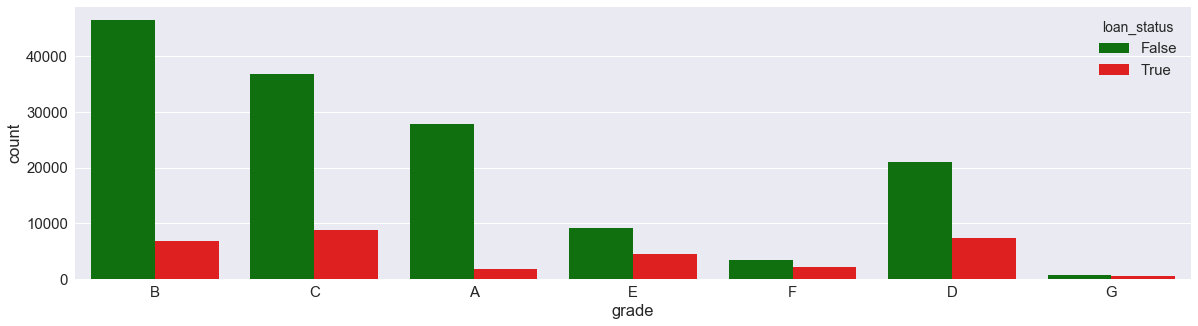

In [72]:
count('grade')

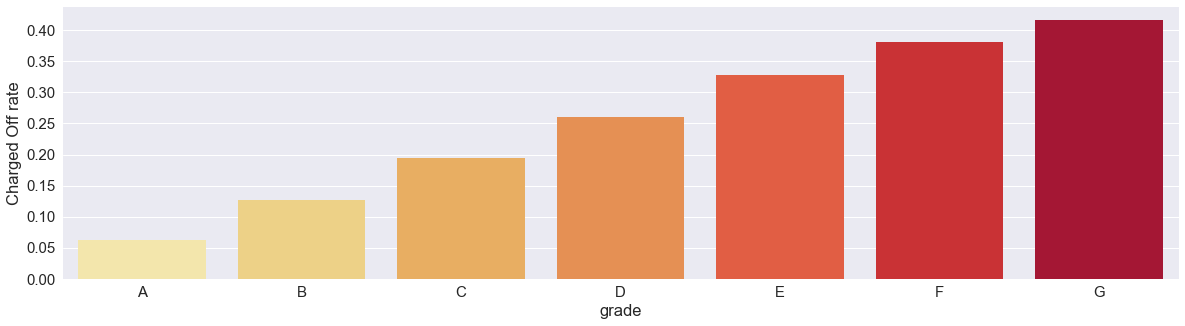

In [73]:
train_grade = rate('grade')

This is clearly a ordinal variable. We could map each grade to 1-7, but we'll obtain a little better correlation if we map it as always

In [74]:
map_to_rate('grade', train_grade)

In [75]:
train['loan_status'].corr(train['grade'])

0.22635162695523123

22.6% OH MY GOD!

### Feature: emp_length
Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 

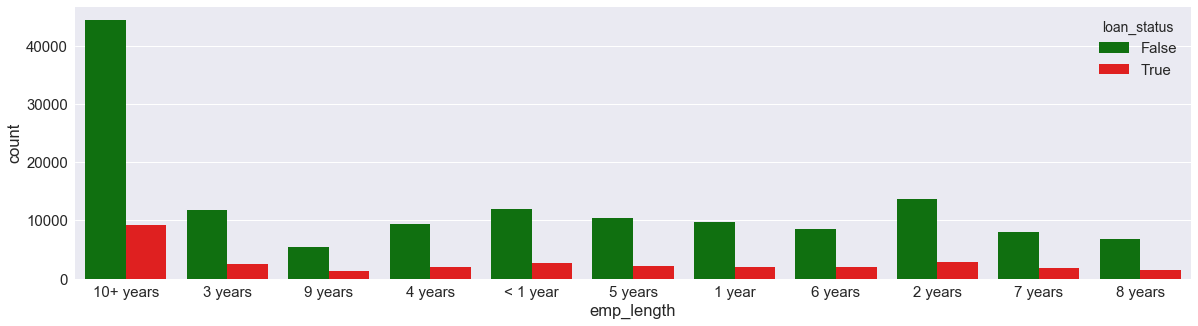

In [76]:
count('emp_length')

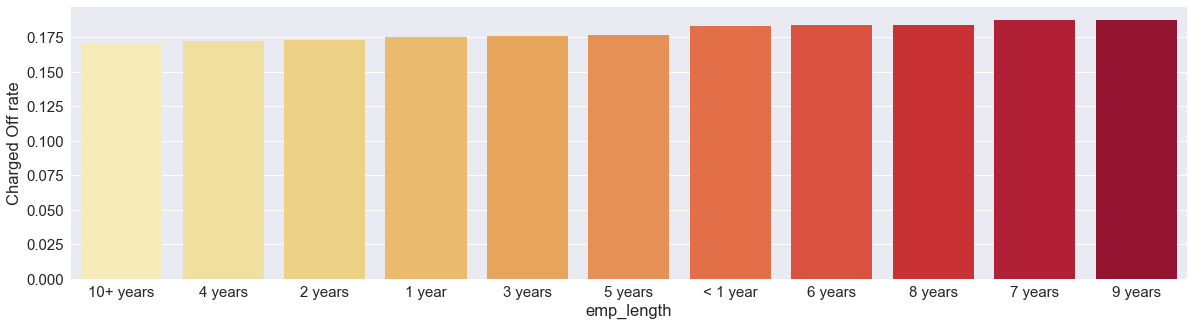

In [77]:
train_emp_length = rate('emp_length')

In [78]:
# Surprisingly, the 'Charged Off' rate doesn't follow the same order
# All rates are very similar, so we don't expect a lot of correlation...

map_to_rate('emp_length', train_emp_length)

In [79]:
# 'emp_length' was another of the few features that had missing values we have to take care of.
# The easiest thing will be to fill them with the median value (per each 'loan_status' value)

medians = {0: train[train['loan_status'] == False]['emp_length'].median(),
           1: train[train['loan_status'] == True]['emp_length'].median(),
           'train': train['emp_length'].median() # for filling the test data missing values
          }
medians

{0: 0.175580997949419, 1: 0.175580997949419, 'train': 0.175580997949419}

In [80]:
# By coincidence, it's the same

train.loc[(train['loan_status']==0) & train['emp_length'].isnull(), 'emp_length'] = medians[0]
train.loc[(train['loan_status']==1) & train['emp_length'].isnull(), 'emp_length'] = medians[1]
test['emp_length'] = test['emp_length'].fillna(medians['train'])

train['loan_status'].corr(train['emp_length'])

0.013942696269017514

Only 1.5%, as we expected
### Feature: term
The number of payments on the loan. Values are in months and can be either 36 or 60

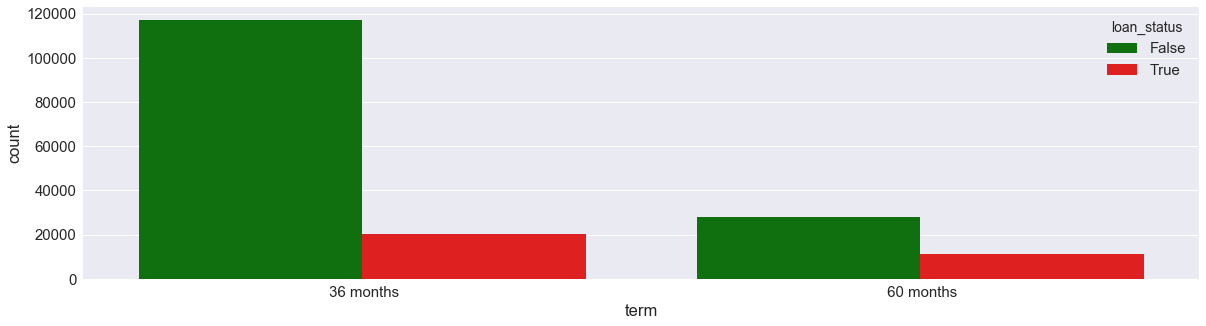

In [81]:
count('term')

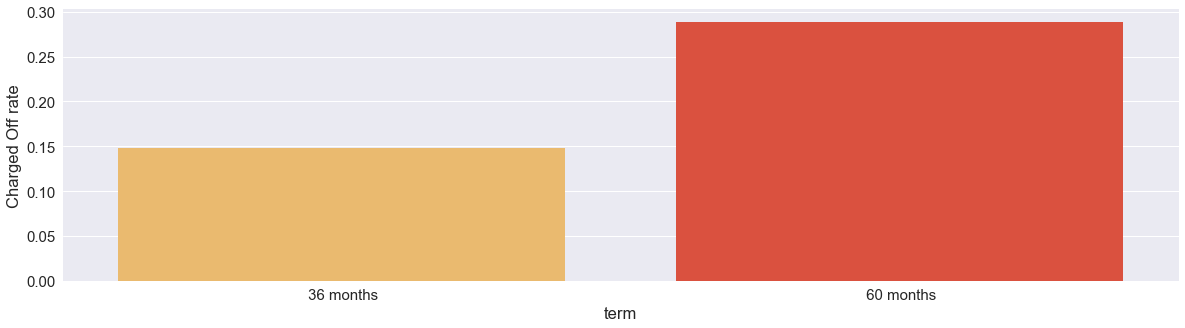

In [82]:
train_term = rate('term')

In [83]:
map_to_rate('term', train_term)
# making it a boolean variable instead would have the same effect.

train['loan_status'].corr(train['term'])

0.15168952322816723

15%, not bad
### Feature: addr_state
The state provided by the borrower in the loan application

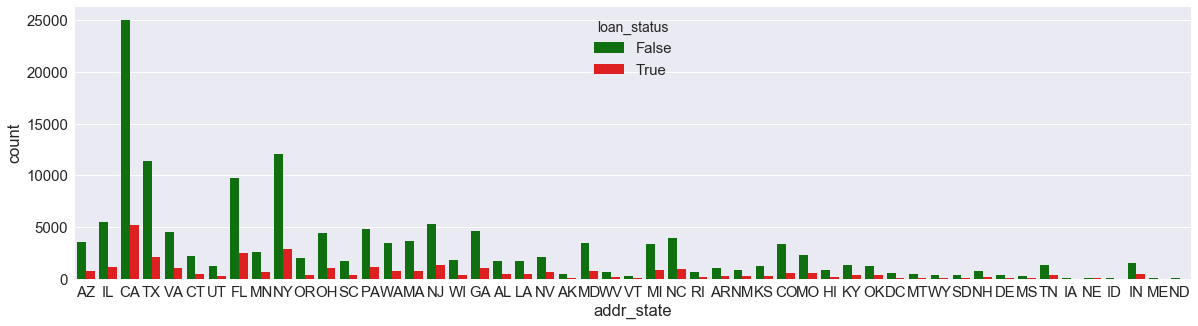

In [84]:
count('addr_state')

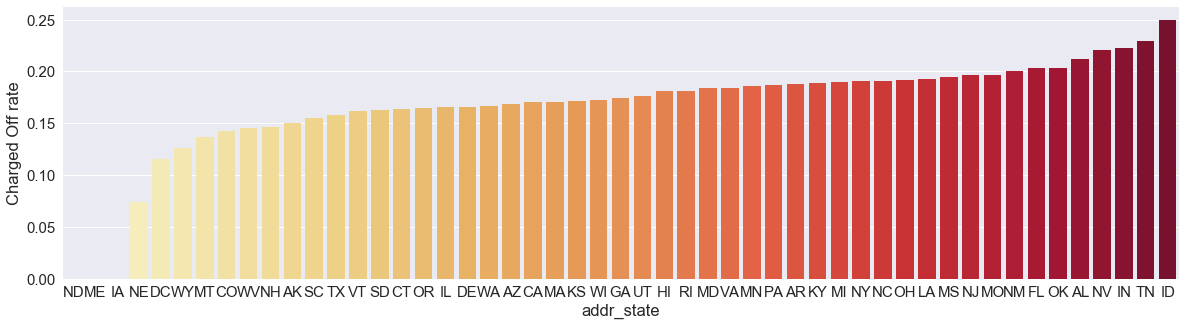

In [85]:
train_addr_state = rate('addr_state')


In [86]:
# Again, let's map this feature to its loan_status rate

map_to_rate('addr_state',train_addr_state)

train['loan_status'].corr(train['addr_state'])

0.04752356663361077

Only 5%, though we already expected something this low

In [87]:
# We should do dummy variables, though first, just to see if we can
# see something interesting, let's create a geographical plot :D

# Get imports and set everything up to be working offline.
import plotly.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Now set up everything so that the figures show up in the notebook:
init_notebook_mode(connected=True)

data = dict(type = 'choropleth',
            locations = train_addr_state['addr_state'].tolist(),
            locationmode = 'USA-states',
            colorscale= 'Portland',
            text= ['text1','text2','text3'],
            z = train_addr_state['loan_status'].tolist(),
            colorbar = {'title':'Charged Off rate'})

layout = dict(geo = {'scope':'usa'})

choromap = go.Figure(data = [data],layout = layout)

iplot(choromap)

### Feature: verification_status
Indicates if the co-borrowers' joint income was verified by LC, not verified, or if the income source was verified

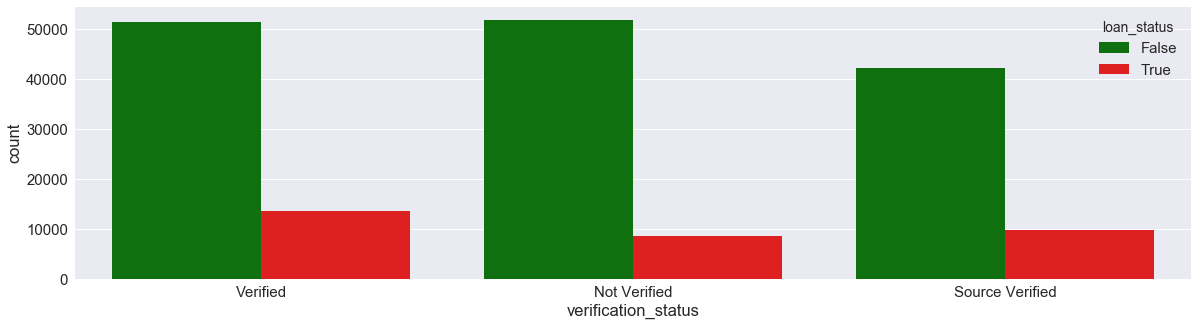

In [88]:
count('verification_status')

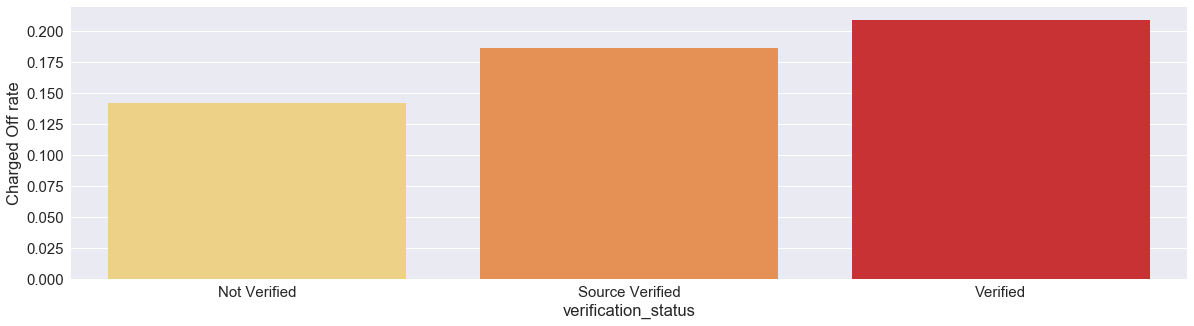

In [89]:
train_verification_status = rate('verification_status')


In [90]:
map_to_rate('verification_status',train_verification_status)

train['loan_status'].corr(train['verification_status'])

0.07443645481301331

7%, it's something ¯\\_(ツ)_/¯
### Feature: application_type
Indicates whether the loan is an individual application or a joint application with two co-borrowers

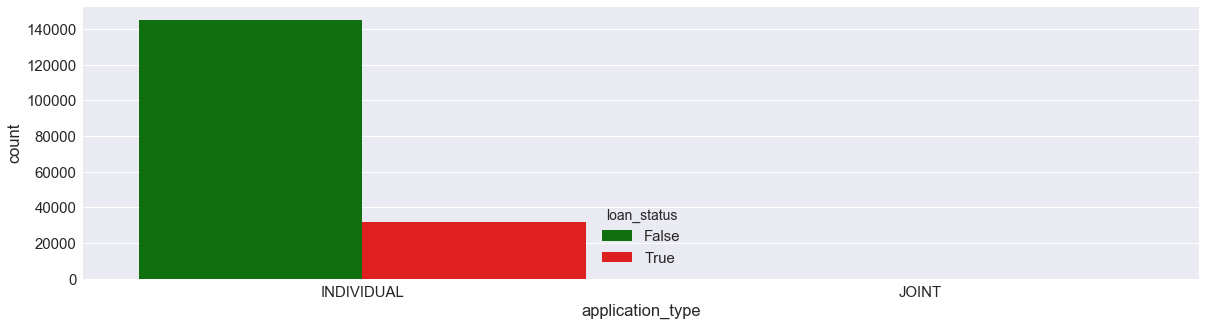

In [91]:
count('application_type')

In [92]:
train['application_type'].value_counts()

INDIVIDUAL    176987
JOINT              1
Name: application_type, dtype: int64

In [93]:
# It's safe to drop this feature, since it's independent
train.drop('application_type', axis = 1, inplace = True)
test.drop('application_type', axis = 1, inplace = True)

In [94]:
# Let's see how our transformed categorical features look now
train[['loan_status','purpose','home_ownership', 'grade', 'emp_length', 'term', 'addr_state', 'verification_status']].head()


,loan_status,purpose,home_ownership,grade,emp_length,term,addr_state,verification_status
0,False,0.157300,0.201777,0.126258,0.170682,0.148541,0.168563,0.209368
2,False,0.294551,0.201777,0.194133,0.170682,0.148541,0.165313,0.142126
3,False,0.206079,0.201777,0.194133,0.170682,0.148541,0.170208,0.186268
5,False,0.139603,0.201777,0.062487,0.175997,0.148541,0.168563,0.186268
7,False,0.120897,0.201777,0.327797,0.187916,0.148541,0.170208,0.186268


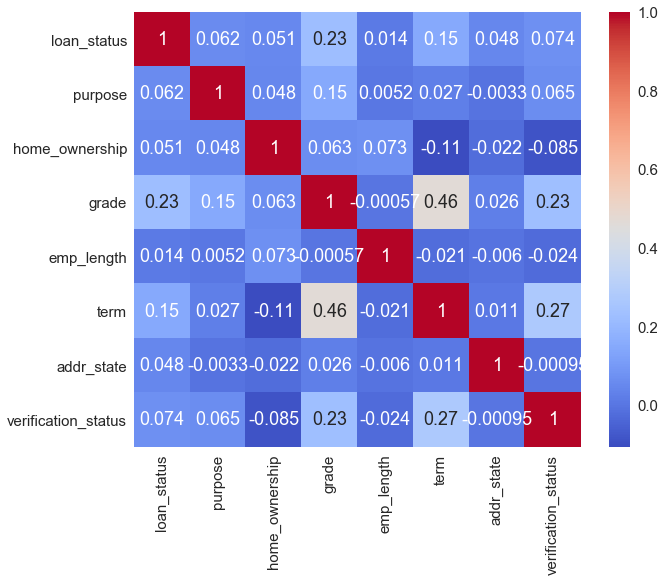

In [95]:
plt.figure(figsize=(10,8))
sns.heatmap(train[['loan_status','purpose','home_ownership', 'grade', 'emp_length', 'term', 'addr_state', 'verification_status']].corr(),cmap='coolwarm',annot=True)


## Model Selection and Development
We've done a very deep exploration of every feature. Now, let's see which models perform best

In [96]:
X_train = train.drop('loan_status',axis=1)
X_test = test.drop('loan_status',axis=1)
y_train = train['loan_status']
y_test = test['loan_status']

### Classifier comparison

In [97]:
from sklearn.metrics import accuracy_score, log_loss, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

classifiers = [
    KNeighborsClassifier(3),
    # SVC(probability=True), # too long to train...
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

In [ ]:
auc_dict = {}

for clf in classifiers:
    name = clf.__class__.__name__
    clf.fit(X_train,y_train)
    train_predictions = clf.predict(X_test)
    # Calculate the fpr and tpr for all thresholds of the classification
    fpr, tpr, thresholds = roc_curve(y_test,train_predictions)
    roc_auc = auc(fpr, tpr)
    auc_dict[name] = roc_auc

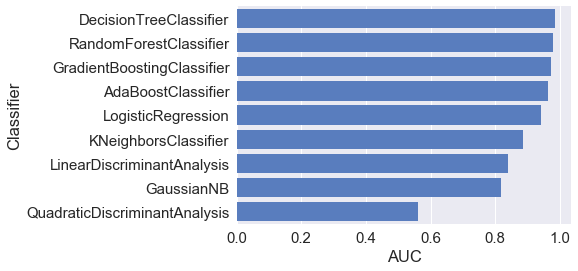

In [99]:
df_auc = pd.DataFrame.from_dict(auc_dict, orient = 'index').reset_index().rename(columns = {0:'AUC',
                                                'index': 'Classifier'}).sort_values('AUC', ascending = False)

sns.set_color_codes("muted")
sns.barplot(x='AUC', y='Classifier',data = df_auc, color='b')

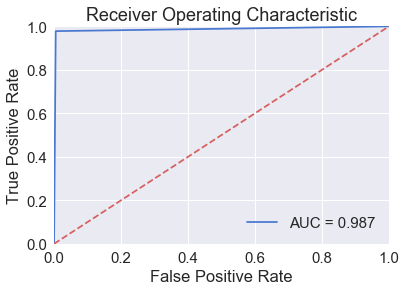

In [102]:
# It seems we have a winner: Decision Tree!
# Let's look at its Area under the Curve
# calculate the fpr and tpr for all thresholds of the classification
model = DecisionTreeClassifier()
name = model.__class__.__name__
model.fit(X_train,y_train)
probs = model.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [103]:
from sklearn.metrics import classification_report

print(classification_report(y_test,preds))

             precision    recall  f1-score   support

      False       1.00      1.00      1.00     62536
       True       0.98      0.98      0.98     13447

avg / total       0.99      0.99      0.99     75983



#### Thanks for watching!